# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks that hide some computation from you. It builds on the first lab, where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates. 

All the frameworks for deep learning you will meet from now on use automatic differentiation (autodiff), so you do not have to code the backward step yourself. In this version of this lab, you will develop your own autodif implementation. We also have an optional [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_Python/2.2-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in NumPy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation. 
2. [NumPy](https://numpy.org/). Part of Anaconda distribution.  If you already know how to program, most things about Python and NumPy can be found with Google searches.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by [Rasmus Berg Palm](https://rasmusbergpalm.github.io) that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop 
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [210]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

from math import exp, log

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])

A few examples illustrate how we can use this:

In [211]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [212]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

#### Solution

What the code does is provide a value and a gradient to each Var, and providing operation overloading to several math operations.
1. When we declare a and b, we initialize a Var object with its value and set its gradient to 0, as no backpropagation has been performed.
2. When we declare f as the multiplication between a and b, we define a gradient function for multiplication that stems from the product rule of derivatives. 
    * Any change in $a$ will have its effect in $f$, where it will be scaled by the value $b.v$, and same the other way around: 
    $\frac{\partial f(a)}{\partial a} = b $, $\frac{\partial f(b)}{\partial b} = a $

3. Calling the backward method starts the backpropagation process by initializing the gradient of f with respect to itself, which is $\partial f / \partial f = 1.0$.
4. The backward method calls the backprop method
    * 2 things happen here:
        * Gradient of f is set to $f.grad + bp = 1.0$ where $bp = 1.0$
        * Gradient function defined is executed, resulting in $\frac{\partial f(a)}{\partial a} = 5.0 $, $\frac{\partial f(b)}{\partial b} =3.0 $
5. For each of the input variables to this node, the backpropagation method is called again recursively.
    * We define bp for each variable: $bp_a = 1.0*5.0$ and $bp_b = 1.0*3.0$
    * We set the gradient for each variable: $a.grad = a.grad + 5.0 = 5.0$ and $b.grad = b.grad + 3.0 = 3.0$

6. And so on...

So in summary, we're seeing each variable's value and gradient. The gradient tells us how much the output node will change if we change the input variables.
a ==> Var(v=3.0000, grad=14.0000) ==> $a$ contributes to $c$ and $e$, which both contribute to $f$
b ==> Var(v=5.0000, grad=3.0000) ==> $b$ contributes to $c$, which contributes to $f$
c ==> Var(v=15.0000, grad=1.0000) ==> $c$ contributes directly to $f$
d ==> Var(v=9.0000, grad=3.0000) ==> $d$ contributes to $e$, which contributes to $f$
e ==> Var(v=27.0000, grad=1.0000) ==> $e$ contributes directly to $f$
f ==> Var(v=42.0000, grad=1.0000) ==> $f$ affects itself




## Exercise b) How does the backward function work?

You need to understand how the backward function calculates the gradients. We can use the two examples above to help with that.

Go through the following four steps and answer the questions on the way:

1. We represent the two expressions as graphs as shown below. Fill in the missing expressions for the different derivatives.

2. In the remainder, consider the first expression. Make a schematic of the data structure generated when we define the expression for f (e.g., write a list of which objects are created and the corresponding values of their member variables).

3. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables. 

4. Write down the sequence of calls to backprop.

In [213]:
# If you have not installed networkx and matplotlib, you can install them by running
# !pip install networkx matplotlib

import networkx as nx
import matplotlib.pyplot as plt

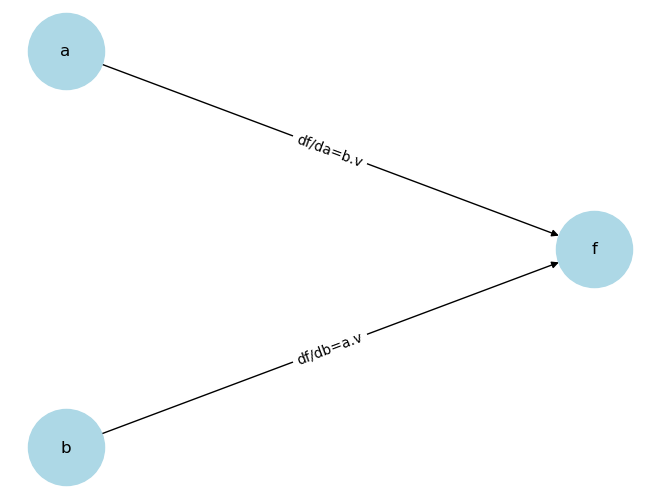

In [214]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'f', label='df/da=b.v')
G.add_edge('b', 'f', label='df/db=a.v')

# Manually define positions for a tree layout
pos = {
    'a': (0, 1),
    'b': (0, -1),
    'f': (1, 0),
}
# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

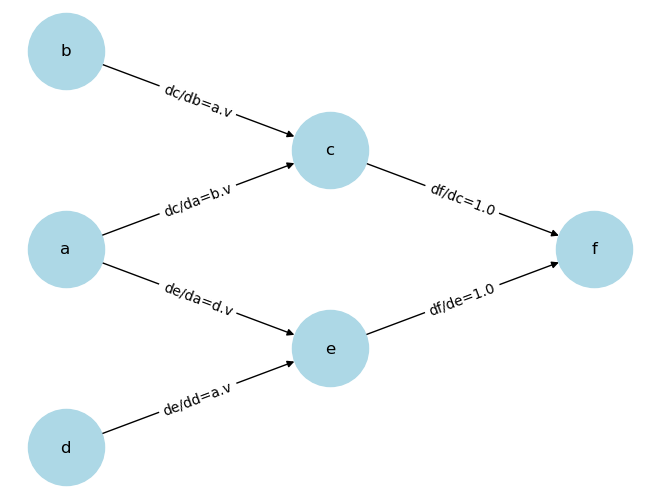

In [215]:
# Create a directed graph
G = nx.DiGraph()

# Add edges with labels
G.add_edge('a', 'c', label='dc/da=b.v')
G.add_edge('b', 'c', label='dc/db=a.v')
G.add_edge('a', 'e', label='de/da=d.v')
G.add_edge('d', 'e', label='de/dd=a.v')
G.add_edge('c', 'f', label='df/dc=1.0')
G.add_edge('e', 'f', label='df/de=1.0')

# Manually define positions for a tree layout
pos = {
    'a': (0, 0),
    'b': (0, 2),
    'c': (1, 1),
    'd': (0, -2),
    'e': (1, -1),
    'f': (2, 0)
}

# Draw the graph nodes and edges
nx.draw(G, pos, with_labels=True, node_shape='o', node_size=3000, node_color='lightblue', arrows=True)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()

### Objects created in first expression:
1. $a$:
    * v = 3.0
    * grad = 0.0
    * grad_fn = lambda: []

2. $b$:
    * v = 5.0
    * grad = 0.0
    * grad_fn = lambda: []

3. $f$:
    * v = a.v*b.v = 15.0
    * grad = 0.0
    * grad_fn = lambda: [(a, b.v), (b, a.v)]

### Backward function execution

1. Initialize gradient of the output with respect to itself to $f.grad = 1.0$
2. Assuming $grad_fn = lambda: [(a, b.v), (b, a.v)]
    * Gradient of $f$ with respect to $a$ is $b.v = 5.0$
    * Gradient of $f$ with respect to $b$ is $a.v = 3.0$
3. With chain rule we multiply gradient of $f$ with each gradient:
    * Gradient of $a = 1.0 * 5.0 = 5.0$
    * Gradient of $b = 1.0 * 3.0 = 3.0$

### Sequence of calls for backprop

1. $f.backprop(1.0)$
2. $a.backprop(5.0)$
3. $b.backprop(3.0)$

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

### Explanation
All previous gradients are saved, so the backpropagation will run again but accumulating the previous gradients, which is why basically we see all the gradients duplicating. In each step that the variable is called to backpropagate, the gradient of that specific variable is increased by the same value as it was in the previous iteration.


In [216]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

### Explanation
Same principle as before. In the previous exercise, we backpropagated another $1.0$, which first results in increasing the output gradient by 1 because we're increasing by the derivative of $f$ with respect to itself. Now, we're doing the same but in the other way. When we backpropagate a $-1.0$, we're subtracting 1 from the derivative of $f$ with respect to itself, resulting in a similar effect on all the other variables where it's gradient will be decreased in the same rate as it was increased.

In [217]:
a = Var(2.0)

for v in [a, b, c, d, e, f]:
    print(v)

f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.

As an example, we could approximate the derivative of the function $f(a)=a^2$ in e.g. the value $a=4$ using the finite difference method. This amounts to inserting the relevant values and approximating the gradient $f'(4)$ with the fraction above. 


In [218]:
# f function - try to change the code to test other types of functions as well (such as different polynomials etc.)
def f_function(a):
  a = Var(a)
  b = Var(5.0)
  f = a * b
  f.backward()
  return a,b,f

for v in f_function(3.0):
  print(v)

# Insert your finite difference code here
def finite_difference(a, da=1e-10):
    """
    This function compute the finite difference between
    
    Input:
    da:          The finite difference                           (float)
    a:           Node where to compute the derivative            (float)
    
    Output:
    finite_difference: numerical approximation to the derivative (float) 
    """
    
    # First we need to compute f(a + da)
    _, _, f_plus_da = f_function(a + da)
    
    _, _, fa = f_function(a)
    finite_difference = (f_plus_da.v - fa.v) / da
    
    return finite_difference

# print(finite_difference(3.0))

# Finite difference approximation
a = 3.0
print("Finite difference approximation:", finite_difference(a))

# Analytical derivative
a_new, _, f = f_function(a)
print("Backpropagation gradient:", a_new.grad)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Finite difference approximation: 5.000000413701855
Backpropagation gradient: 5.0


# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [219]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [220]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)    
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T
    
    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)
    
    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)
    
    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma
    
    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [221]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

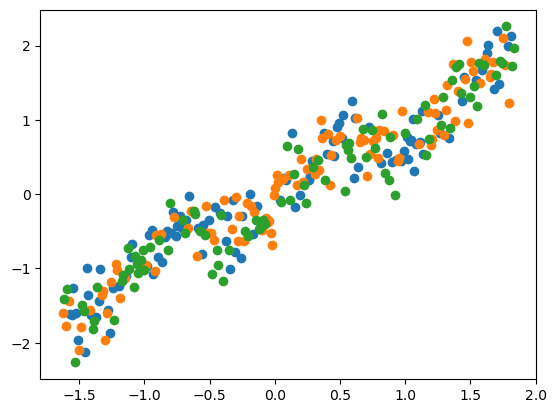

In [222]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [223]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y
   
x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it. 
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [224]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError

  def init_bias(self, n_out):
    raise NotImplementedError

In [225]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [226]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias
  
    def print_parameters(self):
        for i, row in enumerate(self.weights):
            for j, weight in enumerate(row):
                print(f"Layer {i} - Weight input node {i} to output node {j}: {weight}")
        for j, b in enumerate(self.bias):
            print(f"Layer bias for node {j}: {b}")

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input 
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])): 
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j]
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += single_input[i] * weights[i][j]
            node = self.act_fn(node)
            out.append(node)

        return out

## Exercise f) Add more activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu). 
 
Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

### Updated Var class

In [227]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

from math import exp, log, tanh

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])
    
    # New activation functions
    
    def identity(self):
        return Var(self.v, lambda: [(self, 1.0)])
    
    def hyperbolic_tan(self):
        gradient = 1 - tanh(self.v)**2
        return Var(tanh(self.v), lambda: [(self, gradient)])
    
    def sigmoid(self):
        logistic_sigmoid = (1 + exp(-self.v))**-1
        gradient = logistic_sigmoid * (1 - logistic_sigmoid)
        return Var(logistic_sigmoid, lambda: [(self, gradient)])
    
    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

## Exercise g) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. *The forward method in DenseLayer is **not** complete*. It just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

#### Updated DenseLayer

In [ ]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn
    
    def __repr__(self):    
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias
  
    def print_parameters(self):
        for i, row in enumerate(self.weights):
            for j, weight in enumerate(row):
                print(f"Layer {i} - Weight input node {i} to output node {j}: {weight}")
        for j, b in enumerate(self.bias):
            print(f"Layer bias for node {j}: {b}")

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input 
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])): 
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j]
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += single_input[i] * weights[i][j]
            node = self.act_fn(node)
            out.append(node)

        return out

In [228]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))


[[Var(v=-0.0113, grad=0.0000)], [Var(v=-0.0227, grad=0.0000)], [Var(v=-0.0021, grad=0.0000)], [Var(v=-0.0097, grad=0.0000)], [Var(v=-0.0167, grad=0.0000)], [Var(v=-0.0154, grad=0.0000)], [Var(v=-0.0100, grad=0.0000)], [Var(v=-0.0023, grad=0.0000)], [Var(v=-0.0100, grad=0.0000)], [Var(v=-0.0062, grad=0.0000)], [Var(v=-0.0174, grad=0.0000)], [Var(v=-0.0062, grad=0.0000)], [Var(v=-0.0140, grad=0.0000)], [Var(v=-0.0071, grad=0.0000)], [Var(v=-0.0075, grad=0.0000)], [Var(v=-0.0145, grad=0.0000)], [Var(v=-0.0268, grad=0.0000)], [Var(v=-0.0127, grad=0.0000)], [Var(v=-0.0013, grad=0.0000)], [Var(v=-0.0044, grad=0.0000)], [Var(v=-0.0046, grad=0.0000)], [Var(v=-0.0020, grad=0.0000)], [Var(v=-0.0196, grad=0.0000)], [Var(v=-0.0198, grad=0.0000)], [Var(v=-0.0027, grad=0.0000)], [Var(v=-0.0073, grad=0.0000)], [Var(v=-0.0254, grad=0.0000)], [Var(v=-0.0279, grad=0.0000)], [Var(v=-0.0030, grad=0.0000)], [Var(v=-0.0176, grad=0.0000)], [Var(v=-0.0091, grad=0.0000)], [Var(v=-0.0042, grad=0.0000)], [Var(v=

## Exercise h) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var. 

#### Solution:

DenseLayer was updated and you can see updates on previous exercise

In [229]:
# Insert code here and in the DenseLayer class
def print_network_parameters(network):
    for layer_index, layer in enumerate(network):
        print(f"\nParameters of Layer {layer_index}:")
        layer.print_parameters()
        
print_network_parameters(NN)


Parameters of Layer 0:
Layer 0 - Weight input node 0 to output node 0: Var(v=0.1639, grad=0.0000)
Layer 0 - Weight input node 0 to output node 1: Var(v=0.0588, grad=0.0000)
Layer 0 - Weight input node 0 to output node 2: Var(v=-0.0634, grad=0.0000)
Layer 0 - Weight input node 0 to output node 3: Var(v=0.1005, grad=0.0000)
Layer 0 - Weight input node 0 to output node 4: Var(v=0.0678, grad=0.0000)
Layer bias for node 0: Var(v=0.0000, grad=0.0000)
Layer bias for node 1: Var(v=0.0000, grad=0.0000)
Layer bias for node 2: Var(v=0.0000, grad=0.0000)
Layer bias for node 3: Var(v=0.0000, grad=0.0000)
Layer bias for node 4: Var(v=0.0000, grad=0.0000)

Parameters of Layer 1:
Layer 0 - Weight input node 0 to output node 0: Var(v=-0.0683, grad=0.0000)
Layer 1 - Weight input node 1 to output node 0: Var(v=0.0709, grad=0.0000)
Layer 2 - Weight input node 2 to output node 0: Var(v=-0.1006, grad=0.0000)
Layer 3 - Weight input node 3 to output node 0: Var(v=-0.0141, grad=0.0000)
Layer 4 - Weight input 

## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

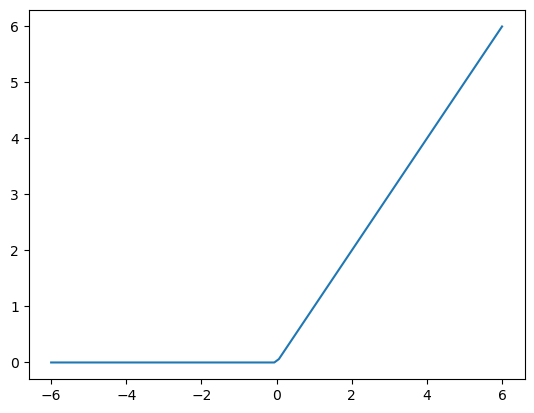

In [230]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray  
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation 
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ] 
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

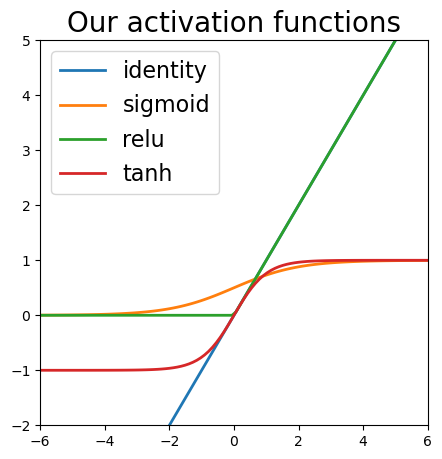

In [231]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.hyperbolic_tan()
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf). 

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer. 

The Glorot initialization has the form: 

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).) 

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization
 
Using the Initializer class, implement functions that implement Glorot and He 

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

#### Explanation

To test numerically the Glorot initialization, I would pass random inputs through the network and then compare that the output variance remains constant across all the layers.
Same for the He initialization. Only thing to consider is the alpha value depending on the activation function used. The variance should remain constant and approximate to this number. 



In [232]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
  alpha = 1
  std = ((2*alpha)/(n_in+n_out))**0.5
  return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
  alpha = 2
  std = ( alpha / n_in )**0.5
  return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions. 

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands. 

In [233]:
# Insert code here
initializer = ConstantInitializer(weight=1.0, bias=0.0)
NN = [
    DenseLayer(2, 4, lambda x: x.identity(), initializer),
    DenseLayer(4, 1, lambda x: x.identity(), initializer)
]

x_test_forward = np.array([[1.0, 2.0]])
x_test_var = nparray_to_Var(x_test_forward)

# Calculate the output manually
# Layer 1 output same for each node: Input_1 * Weight_1 + Input_2 * Weight_2 + Bias = 1.0 * 1 + 2.0 * 1 + 0 = 3.0
# Layer 2 output: Input * weights + bias = [3.0, 3.0, 3.0, 3.0]*[1,1,1,1]^T + 0 = 12.0
# Expected output = 12.0

expected_output = np.array([[12.0]])

real_output = forward(x_test_var, NN)
real_output_np = np.array([[node.v for node in out] for out in real_output])

assert np.allclose(real_output_np, expected_output), f"Forward pass test failed! Expected {expected_output}, got {real_output_np}"





# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [234]:
def squared_loss(t, y):
  
  # add check that sizes agree
  assert len(t) == len(y), "Size of real values and predictions must match"
  
  def squared_loss_single(t, y):
    Loss = Var(0.0)
    for i in range(len(t)): # sum over outputs
      Loss += (t[i]-y[i]) ** 2
    return Loss

  Loss = Var(0.0)
  for n in range(len(t)): # sum over training data
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise k) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i 
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'})} .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where 
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector. 

Call the function to convince yourself it works. 

In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

In [235]:
def cross_entropy_loss(t, h):
    loss = Var(0.0)
    
    # Get exp(hi) in terms of the logit of h
    exp_h = [logit.exp() for logit in h]
    sum_exp_h = Var(sum([i.v for i in exp_h]))
    
    # We apply previous equation to get LogSumExp
    log_sum_exp = sum_exp_h.log()
    
    # Compute the cross entropy loss
    for ti, hi in zip(t, h):
        loss -= ti * hi
        
    loss += log_sum_exp
    
    return loss

# True labels
t = [Var(1.0), Var(0.0), Var(0.0)]

# Logits
h = [Var(2.0), Var(1.0), Var(0.5)]

# Compute the loss
loss = cross_entropy_loss(t, h)

print(f"Cross-Entropy Loss: {loss.v}")

Cross-Entropy Loss: 0.4643687841079447


# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [236]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and the gradients will be calculated:

In [237]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 Weights: [[Var(v=-0.2634, grad=2.5663), Var(v=0.0122, grad=-2.7212), Var(v=0.0328, grad=-6.8783), Var(v=-0.0434, grad=-3.6708), Var(v=-0.0171, grad=10.2647)]] Biases: [Var(v=0.0000, grad=-2.3324), Var(v=0.0000, grad=-2.3377), Var(v=0.0000, grad=-5.9088), Var(v=0.0000, grad=3.3361), Var(v=0.0000, grad=-9.3288)]
Layer 1 
 Weights: [[Var(v=-0.0269, grad=25.1004)], [Var(v=0.0269, grad=-1.2312)], [Var(v=0.0679, grad=-3.3222)], [Var(v=0.0385, grad=4.1374)], [Var(v=-0.1077, grad=1.6304)]] Biases: [Var(v=0.0000, grad=-0.4365)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [238]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [239]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Network before update:
Layer 0 
 Weights: [[Var(v=0.0498, grad=8.4566), Var(v=0.0043, grad=4.4628), Var(v=0.0053, grad=5.6426), Var(v=-0.0064, grad=-1.7827), Var(v=-0.0097, grad=8.0500), Var(v=-0.1333, grad=6.3177), Var(v=0.0480, grad=0.1207), Var(v=0.1852, grad=-1.8534), Var(v=0.0184, grad=0.7462), Var(v=0.0766, grad=9.3142), Var(v=0.2116, grad=-3.0458), Var(v=-0.1186, grad=-1.3290), Var(v=0.0374, grad=-6.6656), Var(v=-0.0204, grad=5.4642), Var(v=-0.0945, grad=5.0797)]] Biases: [Var(v=0.0000, grad=7.2643), Var(v=0.0000, grad=3.8336), Var(v=0.0000, grad=4.8470), Var(v=0.0000, grad=1.6199), Var(v=0.0000, grad=-7.3151), Var(v=0.0000, grad=-5.7409), Var(v=0.0000, grad=0.1037), Var(v=0.0000, grad=-1.5921), Var(v=0.0000, grad=0.6410), Var(v=0.0000, grad=8.0010), Var(v=0.0000, grad=-2.6163), Var(v=0.0000, grad=1.2077), Var(v=0.0000, grad=-5.7258), Var(v=0.0000, grad=-4.9654), Var(v=0.0000, grad=-4.6160)]
Layer 1 
 Weights: [[Var(v=0.0038, grad=0.4132), Var(v=-0.0721, grad=-0.9625), Var(v=-0.

[None, None, None]

In [240]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D: 
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients 
## of the activation functions.

In [241]:
# Initialize training hyperparameters
EPOCHS = 200
LEARN_R = 2e-3 

In [242]:
train_loss = []
val_loss = []

for e in range(EPOCHS):
     
    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()
    
    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))
    
    # Training loss
    train_loss.append(Loss.v)
    
    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)
    
    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100), 
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
        


   0 ( 0.00%) Train loss: 104.451 	 Validation loss: 102.800
  10 ( 5.00%) Train loss: 28.365 	 Validation loss: 20.225
  20 (10.00%) Train loss: 15.286 	 Validation loss: 11.259
  30 (15.00%) Train loss: 14.175 	 Validation loss: 10.522
  40 (20.00%) Train loss: 12.876 	 Validation loss: 9.805
  50 (25.00%) Train loss: 12.465 	 Validation loss: 9.408
  60 (30.00%) Train loss: 12.300 	 Validation loss: 9.213
  70 (35.00%) Train loss: 12.207 	 Validation loss: 9.125
  80 (40.00%) Train loss: 12.127 	 Validation loss: 9.036
  90 (45.00%) Train loss: 12.068 	 Validation loss: 8.980
 100 (50.00%) Train loss: 12.008 	 Validation loss: 8.939
 110 (55.00%) Train loss: 11.969 	 Validation loss: 8.914
 120 (60.00%) Train loss: 11.943 	 Validation loss: 8.896
 130 (65.00%) Train loss: 11.927 	 Validation loss: 8.896
 140 (70.00%) Train loss: 11.915 	 Validation loss: 8.904
 150 (75.00%) Train loss: 11.908 	 Validation loss: 8.925
 160 (80.00%) Train loss: 11.902 	 Validation loss: 8.940
 170 (85

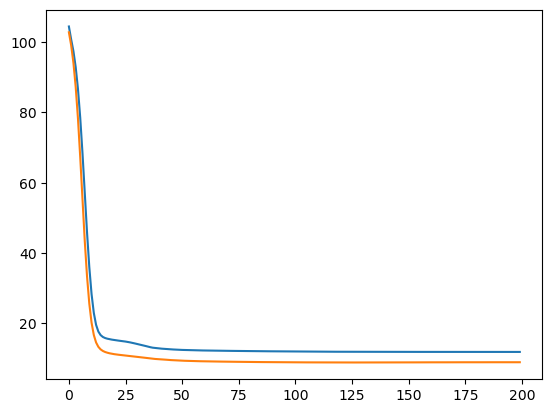

In [243]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [244]:
output_test = forward(x_test, NN)

Test loss:  9.779


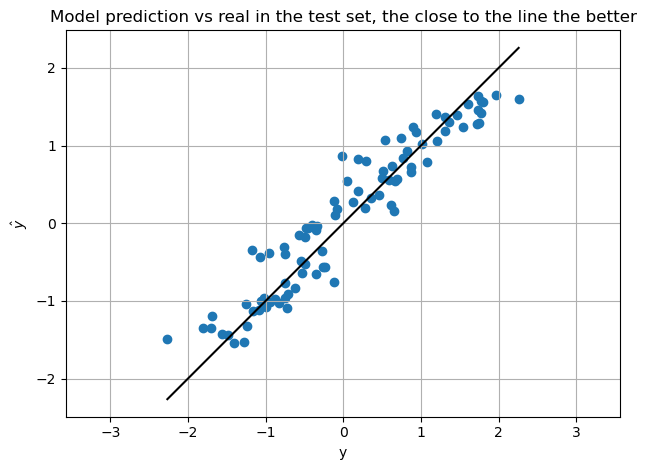

In [245]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

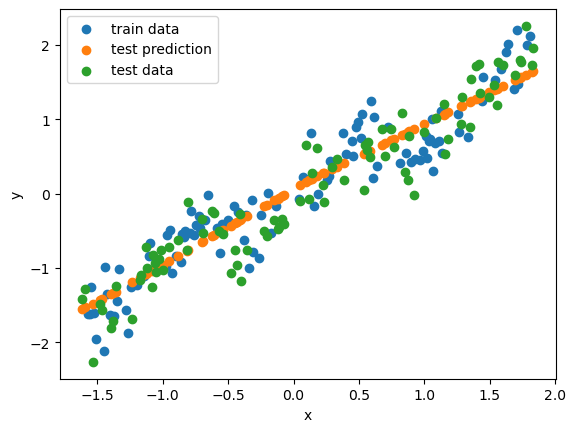

In [246]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise l) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss. 

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.

_Insert written answer here._


In [296]:
def losses(EPOCHS, LEARN_R, network):
    train_loss = []
    val_loss = []

    for e in range(EPOCHS):
        
        # Forward pass and loss computation
        Loss = squared_loss(y_train, forward(x_train, network))

        # Backward pass
        Loss.backward()
        
        # gradient descent update
        update_parameters(parameters(network), LEARN_R)
        zero_gradients(parameters(network))
        
        # Training loss
        train_loss.append(Loss.v)
        
        # Validation
        Loss_validation = squared_loss(y_validation, forward(x_validation, network))
        val_loss.append(Loss_validation.v)
        
        if e%10==0:
            print("{:4d}".format(e),
                "({:5.2f}%)".format(e/EPOCHS*100), 
                "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))
    
    output_test = forward(x_test, network)
            
            
    x_test_np = Var_to_nparray(x_test)
    x_train_np = Var_to_nparray(x_train)
    y_train_np = Var_to_nparray(y_train)
    if D1:
        plt.scatter(x_train_np, y_train_np, label="train data");
        plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
        plt.scatter(x_test_np, y_test_np, label="test data");
        plt.legend();
        plt.xlabel("x");
        plt.ylabel("y");
    else:
        plt.scatter(x_train_np[:,1], y_train, label="train data");
        plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
        plt.scatter(x_test_np[:,1], y_test_np, label="test data");
        plt.legend();
        plt.xlabel("x");
        plt.ylabel("y");

    Loss_test = squared_loss(y_test, forward(x_test, network))

    print("Test loss:  {:4.3f}".format(Loss_test.v))

### Underfitting: 
We just need to lower the EPOCHS so that it doesn't fully train, and use a low number of layers.

We can clearly see on the resulting plot how the model doesn't predict very accurately and is just very generic.

   0 ( 0.00%) Train loss: 105.626 	 Validation loss: 104.974
Test loss:  74.564


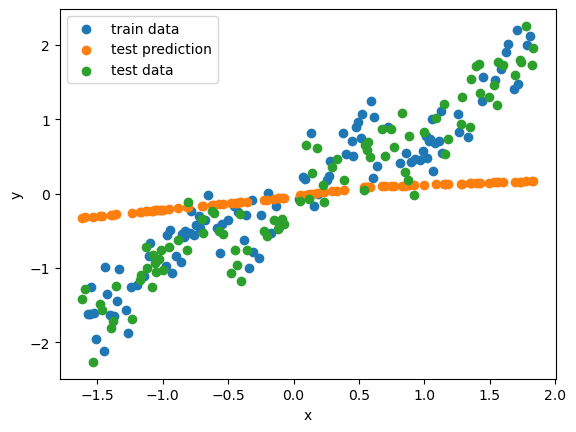

In [297]:
# Underfitting:
NN = [
    DenseLayer(1, 8, lambda x: x.relu()),
    DenseLayer(8, 1, lambda x: x.identity())
]

EPOCHS = 5
LEARN_R = 2e-3  

losses(EPOCHS, LEARN_R,NN)




### Overfitting: 
We just need to increase the EPOCHS so that it fully trains on the training data, and use a large number of layers so that it trains specifically for the training data.

We can clearly see on the resulting plot how the model predicts accurately the training data but fails to work accurately on the test data.

   0 ( 0.00%) Train loss: 106.461 	 Validation loss: 119.976
  10 ( 5.00%) Train loss: 1433.323 	 Validation loss: 379.574
  20 (10.00%) Train loss: 84.811 	 Validation loss: 84.187
  30 (15.00%) Train loss: 35.673 	 Validation loss: 30.509
  40 (20.00%) Train loss: 16.238 	 Validation loss: 12.505
  50 (25.00%) Train loss: 15.336 	 Validation loss: 11.535
  60 (30.00%) Train loss: 14.757 	 Validation loss: 11.180
  70 (35.00%) Train loss: 14.277 	 Validation loss: 10.893
  80 (40.00%) Train loss: 13.942 	 Validation loss: 10.674
  90 (45.00%) Train loss: 13.652 	 Validation loss: 10.461
 100 (50.00%) Train loss: 13.451 	 Validation loss: 10.295
 110 (55.00%) Train loss: 13.300 	 Validation loss: 10.152
 120 (60.00%) Train loss: 13.166 	 Validation loss: 10.027
 130 (65.00%) Train loss: 13.079 	 Validation loss: 9.935
 140 (70.00%) Train loss: 13.004 	 Validation loss: 9.854
 150 (75.00%) Train loss: 12.941 	 Validation loss: 9.778
 160 (80.00%) Train loss: 12.888 	 Validation loss: 9.

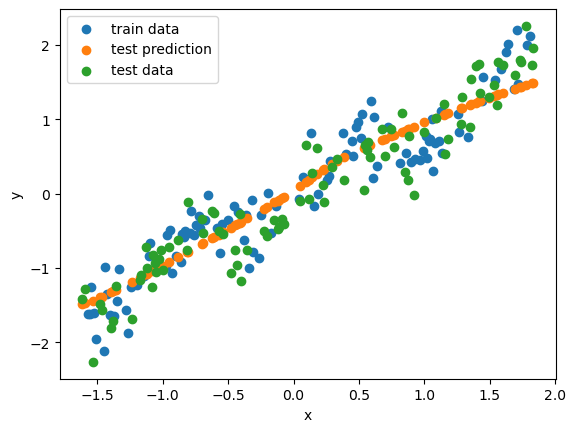

In [300]:
# Overfitting:

overfitting_NN = [
    DenseLayer(1, 30, lambda x: x.relu()),
    DenseLayer(30, 20, lambda x: x.sigmoid()),
    DenseLayer(20, 1, lambda x: x.identity())
]

EPOCHS = 200
LEARN_R = 2e-3 

losses(EPOCHS, LEARN_R, overfitting_NN)

### Just right fitting: 
We just need to select a right amount of EPOCHS for it to train on the training data but not so much, and also select a decent amount of layers and nodes.

We can clearly see on the resulting plot how the model adjusts well to both training and test data

   0 ( 0.00%) Train loss: 105.318 	 Validation loss: 106.981
  10 (20.00%) Train loss: 103.576 	 Validation loss: 106.347
  20 (40.00%) Train loss: 100.751 	 Validation loss: 103.148
  30 (60.00%) Train loss: 91.603 	 Validation loss: 92.325
  40 (80.00%) Train loss: 59.207 	 Validation loss: 55.060
Test loss:  18.458


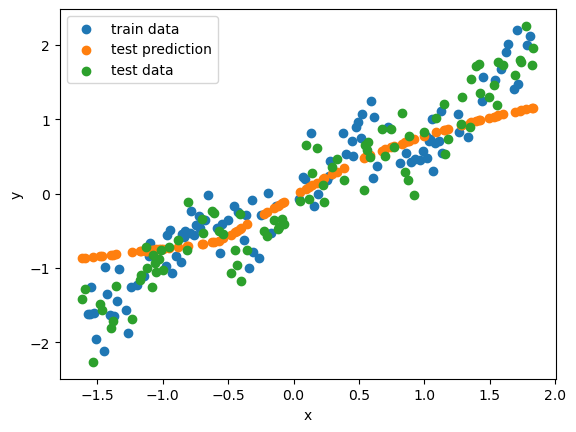

In [301]:
# Just right fitting
rightfit_NN = [
    DenseLayer(1, 25, lambda x: x.relu()),
    DenseLayer(25, 10, lambda x: x.sigmoid()),
    DenseLayer(10, 1, lambda x: x.identity())
]

EPOCHS = 50
LEARN_R = 2e-3 

losses(EPOCHS, LEARN_R, rightfit_NN)

# Next steps - classification

It is straight forward to extend what we have done to classification. 

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week. 

Next week we will see how to perform classification in PyTorch.

## Exercise m) optional - Implement backpropagation for classification

Should be possible with very few lines of code. :-)

In [248]:
# Just add code.

## Exercise n) optional - Introduce a NeuralNetwork class

The functions we applied on the neural network (parameters, update_parameters and zero_gradients) can more naturally be included as methods in a NeuralNetwork class. Make such a class and modify the code to use it. 

In [249]:
# just add some code